In [41]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt 
from PIL import Image
import os 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchinfo import summary
import torchvision.models as models

# 전처리 & dataset 생성

In [42]:
preprocessing = transforms.Compose([
    transforms.Resize(size = (50,50)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [43]:
file_dir = './8moods'
imgDS = ImageFolder(root = file_dir, transform = preprocessing)

In [44]:
print(imgDS.class_to_idx)

{'angry_mood': 0, 'anxiety_mood': 1, 'depressed_mood': 2, 'dynamic_mood': 3, 'happy_mood': 4, 'peaceful_mood': 5, 'tired_mood': 6, 'withered_mood': 7}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


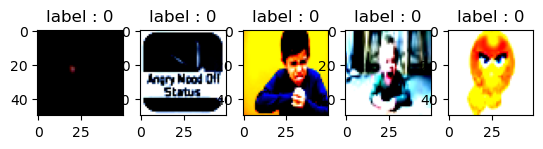

In [45]:
k = 1
for (img, label) in imgDS:
    plt.subplot(1,5,k)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"label : {label}")
    k += 1
    if k == 6 : break
plt.show()


In [46]:
seed = torch.Generator().manual_seed(42)
train, val, test = 0.7, 0.1, 0.2
trainDS, validDS, testDS = random_split(imgDS, [train, val, test], generator = seed)

# DataLoader

In [47]:
# 각 분류별로 dataloader를 생성해보자
batch_size = 10
train_dl = DataLoader(trainDS, batch_size = batch_size, shuffle=True)
valid_dl = DataLoader(validDS, batch_size = batch_size, shuffle=True)
test_dl = DataLoader(testDS, batch_size = batch_size, shuffle=True)

1개의 배치 안에 있는 이미지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


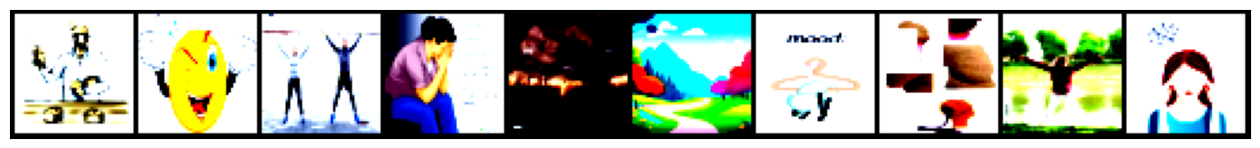

In [48]:
from torchvision.utils import make_grid

def show_batch(dl):
    """Plot images grid of single batch"""
    for (images, labels) in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

# model class 생성

cnn은 합성곱층, 풀링층, 벡터화층, 전결합층이 필요하다!

In [49]:
# 사전 학습된 모델 로딩
import torchvision.models as models # 다양한모델패키지
model = models.vgg16(pretrained=True)

# 사전 훈련된 모델의 파라미터 학습 유무 설정 함수
def set_parameter_requires_grad(model, feature_extract = True):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False # 학습하는 것을 방지

set_parameter_requires_grad(model) # 함수 호출

In [50]:
# 분류기 부분을 이진 분류기로 수정하는 클래스 정의
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        # VGG16의 특성 추출기 부분만 가져오기
        self.features = model.features
        # VGG16의 특성 추출기의 출력 크기 계산
        self.num_features = 512 * 1 * 1  # VGG16은 입력 이미지를 224x224 크기로 처리하므로, 50x50으로 하면 위 공식에 따라 1x1로 출력됩니다.
        
        # 이진 분류를 위한 새로운 fully connected layer 정의
        self.fc = nn.Sequential(
            nn.Linear(self.num_features, 4096),  # 특성 추출기의 출력 크기를 입력으로 받음
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 8),  # 이진 분류를 위한 출력 뉴런 수
            nn.Sigmoid()  # 이진 분류를 위한 시그모이드 활성화 함수
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

# 모델 생성
model = BinaryClassifier()

# 특성 추출기 부분의 파라미터를 고정시킴
set_parameter_requires_grad(model)

# 모델 구조 확인
print(model)

BinaryClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

# 학습 위한 변수 선언

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = BinaryClassifier().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01) # lr은 default로 함

In [52]:
model

BinaryClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [53]:
for param in model.fc.parameters(): # 완전연결층은학습
    param.requires_grad = True

# 함수 만들긔

In [54]:
import torchmetrics as mt
# 배치 크기는 10 , class 개수는 8

In [55]:
def training(DATALOADER):
    model.train()
    loss_list = []
    acc_list = []
    for (feature, target) in DATALOADER:
        feature = feature.to(device)
        target = target.to(device)
        pred = model(feature)

        # 손실계산
        loss = loss_fn(pred, target)

        # 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 성능
        accuracy = mt.Accuracy(num_classes= 8, task = 'multiclass')
        acc = accuracy(pred, target).item()
        acc_list.append(acc)
        loss_list.append(loss.item())
        
    total_acc = round(sum(acc_list)/len(acc_list) , 3)
    total_loss = round(sum(loss_list)/len(loss_list), 3)
    return total_loss, total_acc

# training(train_dl)

In [56]:
def testing(DATALOADER):
    model.train()
    loss_list = []
    acc_list = []
    for (feature, target) in DATALOADER:
        feature = feature.to(device)
        target = target.to(device)
        pred = model(feature)

        # 손실계산
        loss = loss_fn(pred, target)

        # 성능
        accuracy = mt.Accuracy(num_classes= 8, task = 'multiclass')
        acc = accuracy(pred, target).item()
        acc_list.append(acc)
        loss_list.append(loss.item())

    total_acc = round(sum(acc_list)/len(acc_list) , 3)
    total_loss = round(sum(loss_list)/len(loss_list), 3)
    return total_loss, total_acc

In [57]:
EPOCH = 5
train_list = [[], []]
val_list = [[], []]
for epo in range(EPOCH):
    loss, acc = training(train_dl)
    train_list[0].append(loss)
    train_list[1].append(acc)

    loss, acc = testing(valid_dl)
    val_list[0].append(loss)
    val_list[1].append(acc)
    print('.', end = ' ')
    
    if epo%50 == 0 : print(epo)
print('DONE')

. 0
. . . . DONE


In [58]:
epo_list = [ k for k in range(1, EPOCH+1)]

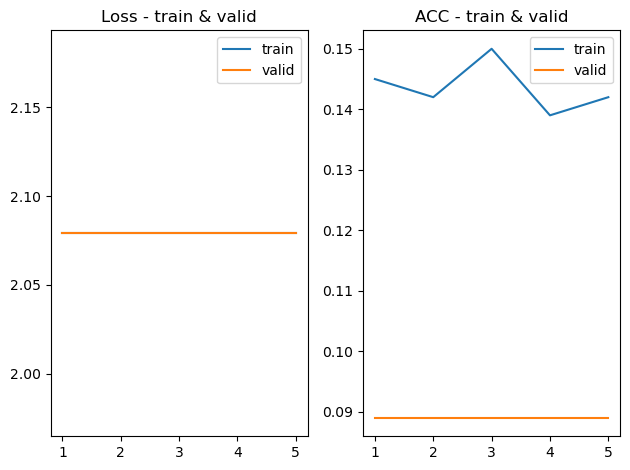

In [59]:
plt.subplot(1,2,1)
plt.plot(epo_list, train_list[0], label = 'train')
plt.plot(epo_list, val_list[0], label = 'valid')
plt.legend()
plt.title('Loss - train & valid')

plt.subplot(1,2,2)
plt.plot(epo_list, train_list[1], label = 'train')
plt.plot(epo_list, val_list[1], label = 'valid')
plt.legend()
plt.title('ACC - train & valid')

plt.tight_layout()
plt.show()

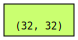

In [60]:
from torchviz import make_dot
y_pred = torch.randint(low = 0, high = 255, size = (32, 32) )
make_dot(y_pred, params = dict(model.named_parameters()))

# 예측

In [61]:
def predicting(DATALOADER):
    model.train()
    loss_list = []
    acc_list = []
    for (feature, target) in DATALOADER:
        feature = feature.to(device)
        target = target.to(device)
        pred = model(feature)

        # 손실계산
        loss = loss_fn(pred, target)

        # 성능
        accuracy = mt.Accuracy(num_classes= 8, task = 'multiclass')
        acc = accuracy(pred, target).item()
        acc_list.append(acc)
        loss_list.append(loss.item())

    total_acc = round(sum(acc_list)/len(acc_list) , 3)
    total_loss = round(sum(loss_list)/len(loss_list), 3)
    print(f"predict loss : {total_loss}   predict acc : {total_acc}")
    return total_loss, total_acc

predicting(test_dl)

predict loss : 2.079   predict acc : 0.111


(2.079, 0.111)

# 모델 저장

In [62]:
## 학습 중 모델 저장 관련 변수
dir = './model/'
filename = dir + f"mood_{EPOCH}.pth"
print(filename)

./model/mood_5.pth


In [63]:
torch.save(model.state_dict(), filename)
print('모델 저장 완료')

모델 저장 완료
